In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt

In [5]:
#load train and test data (marker traits/correlations on sim and real populations)
real_cors = pd.read_csv("stats/pheno_prediction/real_cors.csv")
sim_cors = pd.read_csv("stats/pheno_prediction/sim_cors.csv")

real_parent_trait = pd.read_csv("stats/pheno_prediction/real_parent_trait_map.csv")
sim_parent_trait = pd.read_csv("stats/pheno_prediction/sim_parent_trait_map.csv")

real_phenos = pd.read_csv("stats/pheno_prediction/real_summary_all.csv")
sim_phenos = pd.read_csv("stats/pheno_prediction/sim_summary_all.csv")

#load genmap for marker data
genmap = pd.read_csv("data/sim_data/B73_genmap.csv")

In [10]:
real_parent_trait

,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,PZA00175.2,...,PZA03604.1,PZA00130.9,PZA02969.9,PZA02049.1,PZA00007.1,PHM5435.25,PZA01073.1,PZA01001.2,PZA02578.1,PZA00062.4
0,0.030777,0.036167,-0.055993,-0.131680,0.024888,0.030791,-0.053735,0.050903,0.088392,0.120965,...,-0.045422,-0.156327,-0.065606,-0.037002,-0.184415,0.030437,0.019492,-0.049043,-0.083028,0.073480
1,-0.030777,-0.036167,0.055993,0.131680,-0.024888,0.030791,-0.053735,-0.050903,-0.088392,0.120965,...,0.045422,-0.156327,0.065606,0.037002,0.184415,-0.030437,-0.019492,0.049043,0.083028,-0.073480
2,0.931497,3.536037,1.784706,4.290881,2.735375,2.030305,1.818116,0.000000,4.222884,2.334730,...,3.756031,1.229099,0.858819,3.407341,1.488583,3.220602,3.921778,13.267878,5.608550,0.421064
3,0.030777,0.036167,-0.055993,-0.131680,0.024888,0.030791,-0.053735,0.050903,0.088392,0.120965,...,-0.045422,-0.156327,-0.065606,-0.037002,-0.184415,0.030437,0.019492,-0.049043,-0.083028,0.073480
4,0.030777,-0.036167,-0.055993,0.131680,-0.024888,-0.030791,0.053735,-0.050903,-0.088392,0.120965,...,0.045422,0.000000,0.065606,-0.037002,-0.184415,-0.030437,-0.019492,-0.049043,0.083028,-0.073480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,-0.030777,-0.036167,0.055993,0.131680,-0.024888,-0.030791,0.053735,-0.050903,-0.088392,-0.120965,...,0.045422,0.156327,-0.065606,-0.037002,-0.184415,0.030437,-0.019492,0.049043,0.083028,-0.073480
71,0.931497,3.536037,1.784706,4.290881,2.735375,2.030305,1.818116,0.000000,4.222884,2.334730,...,3.756031,1.229099,0.858819,3.407341,1.488583,3.220602,3.921778,13.267878,5.608550,0.421064
72,0.030777,0.036167,-0.055993,-0.131680,0.024888,0.030791,-0.053735,0.050903,0.088392,0.120965,...,-0.045422,-0.156327,-0.065606,-0.037002,-0.184415,0.030437,0.019492,-0.049043,-0.083028,0.073480
73,-0.030777,-0.036167,0.055993,0.131680,-0.024888,-0.030791,0.053735,-0.050903,-0.088392,-0.120965,...,0.045422,0.156327,-0.065606,-0.037002,-0.184415,0.030437,-0.019492,0.049043,0.083028,-0.073480


In [17]:
#join train and test data with genmap information
recomb_rate = genmap["Rate(cM/Mb)"]
window_size = 20

#calculate non-overlapping rolling average of marker rate with window size of trait correlation
recomb_avg = [recomb_rate[i:i+window_size].mean() for i in range(0, len(recomb_rate), window_size)]

#remove last markers with size smaller than window size
recomb_avg = recomb_avg[0:len(recomb_avg)-1]

#join correlation with average comb rate information
real_cor_avg = [np.concatenate([real_cors.iloc[i].to_numpy(), np.array(recomb_avg)]) for i in range(0, len(real_cors))]
sim_cor_avg = [np.concatenate([sim_cors.iloc[i].to_numpy(), np.array(recomb_avg)]) for i in range(0, len(sim_cors))]

#reshape samples into CNN compatible structure (batchsize,kernel_x(trait_cor & recomb_avg),kernel_y(num_features),channels)
real_x = np.array(real_cor_avg).reshape((len(real_cors),2,48,1))
sim_x = np.array(sim_cor_avg).reshape((len(sim_cors),2,48,1))
real_y = real_phenos["trait_mean"]
sim_y = sim_phenos["trait_mean"]

In [19]:
#train CNN model on parental correlations and genmap rate
kernel_x = 2
kernel_y = 48
model = models.Sequential()
#Convolute on (2, 5) window
model.add(layers.Conv2D(32, (2, 5), activation='relu', input_shape=(kernel_x, kernel_y, 1)))
model.add(layers.MaxPooling2D((1, 4)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

#compile model
model.compile(optimizer='adam', loss='mean_squared_error')

#print summary
model.summary()

#train model on simulated data
history = model.fit(sim_x, sim_y, epochs=500, batch_size=1)

#evaluate model on real data
loss = model.evaluate(real_x, real_y)
print("Test Loss:", loss)

#predict on real data
predictions = model.predict(real_x)

#compare predicted and true real values
for i in range(len(predictions)):
    print(f"Sample {i + 1}: Predicted={predictions[i][0]}, True={real_y[i]}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1, 44, 32)         352       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 11, 32)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 352)               0         
                                                                 
 dense (Dense)               (None, 32)                11296     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11681 (45.63 KB)
Trainable params: 11681 (45.63 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

96/96 [==============================] - 0s 1ms/step - loss: 6.0777
Epoch 88/500
96/96 [==============================] - 0s 2ms/step - loss: 5.4843
Epoch 89/500
96/96 [==============================] - 0s 2ms/step - loss: 5.1555
Epoch 90/500
96/96 [==============================] - 0s 1ms/step - loss: 5.8203
Epoch 91/500
96/96 [==============================] - 0s 1ms/step - loss: 6.2847
Epoch 92/500
96/96 [==============================] - 0s 1ms/step - loss: 4.6936
Epoch 93/500
96/96 [==============================] - 0s 1ms/step - loss: 5.4472
Epoch 94/500
96/96 [==============================] - 0s 1ms/step - loss: 5.6953
Epoch 95/500
96/96 [==============================] - 0s 1ms/step - loss: 4.7706
Epoch 96/500
96/96 [==============================] - 0s 1ms/step - loss: 5.2450
Epoch 97/500
96/96 [==============================] - 0s 1ms/step - loss: 5.1763
Epoch 98/500
96/96 [==============================] - 0s 1ms/step - loss: 4.4734
Epoch 99/500
96/96 [=====================

96/96 [==============================] - 0s 1ms/step - loss: 0.8714
Epoch 188/500
96/96 [==============================] - 0s 1ms/step - loss: 1.5774
Epoch 189/500
96/96 [==============================] - 0s 1ms/step - loss: 1.2166
Epoch 190/500
96/96 [==============================] - 0s 1ms/step - loss: 1.4466
Epoch 191/500
96/96 [==============================] - 0s 1ms/step - loss: 0.8578
Epoch 192/500
96/96 [==============================] - 0s 1ms/step - loss: 0.5239
Epoch 193/500
96/96 [==============================] - 0s 1ms/step - loss: 0.6821
Epoch 194/500
96/96 [==============================] - 0s 2ms/step - loss: 0.9209
Epoch 195/500
96/96 [==============================] - 0s 1ms/step - loss: 0.6045
Epoch 196/500
96/96 [==============================] - 0s 1ms/step - loss: 0.6456
Epoch 197/500
96/96 [==============================] - 0s 1ms/step - loss: 0.6868
Epoch 198/500
96/96 [==============================] - 0s 1ms/step - loss: 0.6772
Epoch 199/500
96/96 [=========

96/96 [==============================] - 0s 1ms/step - loss: 0.1207
Epoch 288/500
96/96 [==============================] - 0s 1ms/step - loss: 0.0978
Epoch 289/500
96/96 [==============================] - 0s 2ms/step - loss: 0.1375
Epoch 290/500
96/96 [==============================] - 0s 1ms/step - loss: 0.1547
Epoch 291/500
96/96 [==============================] - 0s 1ms/step - loss: 0.0742
Epoch 292/500
96/96 [==============================] - 0s 1ms/step - loss: 0.0728
Epoch 293/500
96/96 [==============================] - 0s 1ms/step - loss: 0.1048
Epoch 294/500
96/96 [==============================] - 0s 1ms/step - loss: 0.2262
Epoch 295/500
96/96 [==============================] - 0s 1ms/step - loss: 0.4347
Epoch 296/500
96/96 [==============================] - 0s 1ms/step - loss: 0.5431
Epoch 297/500
96/96 [==============================] - 0s 1ms/step - loss: 0.4660
Epoch 298/500
96/96 [==============================] - 0s 1ms/step - loss: 0.2812
Epoch 299/500
96/96 [=========

96/96 [==============================] - 0s 1ms/step - loss: 0.2719
Epoch 388/500
96/96 [==============================] - 0s 1ms/step - loss: 0.1629
Epoch 389/500
96/96 [==============================] - 0s 1ms/step - loss: 0.1711
Epoch 390/500
96/96 [==============================] - 0s 1ms/step - loss: 0.2446
Epoch 391/500
96/96 [==============================] - 0s 1ms/step - loss: 0.2628
Epoch 392/500
96/96 [==============================] - 0s 1ms/step - loss: 0.1905
Epoch 393/500
96/96 [==============================] - 0s 1ms/step - loss: 0.1838
Epoch 394/500
96/96 [==============================] - 0s 1ms/step - loss: 0.1876
Epoch 395/500
96/96 [==============================] - 0s 1ms/step - loss: 0.1724
Epoch 396/500
96/96 [==============================] - 0s 1ms/step - loss: 0.1277
Epoch 397/500
96/96 [==============================] - 0s 1ms/step - loss: 0.2029
Epoch 398/500
96/96 [==============================] - 0s 1ms/step - loss: 0.1924
Epoch 399/500
96/96 [=========

96/96 [==============================] - 0s 1ms/step - loss: 0.0492
Epoch 488/500
96/96 [==============================] - 0s 1ms/step - loss: 0.0479
Epoch 489/500
96/96 [==============================] - 0s 1ms/step - loss: 0.1392
Epoch 490/500
96/96 [==============================] - 0s 1ms/step - loss: 0.4493
Epoch 491/500
96/96 [==============================] - 0s 1ms/step - loss: 0.4412
Epoch 492/500
96/96 [==============================] - 0s 1ms/step - loss: 0.3850
Epoch 493/500
96/96 [==============================] - 0s 1ms/step - loss: 0.2774
Epoch 494/500
96/96 [==============================] - 0s 1ms/step - loss: 0.2141
Epoch 495/500
96/96 [==============================] - 0s 1ms/step - loss: 0.1585
Epoch 496/500
96/96 [==============================] - 0s 1ms/step - loss: 0.1442
Epoch 497/500
96/96 [==============================] - 0s 1ms/step - loss: 0.2040
Epoch 498/500
96/96 [==============================] - 0s 1ms/step - loss: 0.2289
Epoch 499/500
96/96 [=========

In [5]:
np.sqrt(loss)

15.910305383078368

In [6]:
model.layers

In [57]:
genmap

,Marker,Chromosome,Position(bp),Rate(cM/Mb),Map(cM)
0,PZA01271.1,1,1947984,0.931497,0.0
1,PZA03613.1,1,2914171,3.536037,0.9
2,PZA02129.1,1,3706018,1.784706,3.7
3,PZA02032.1,1,4490461,4.290881,5.1
4,PHM2244.142,1,5562502,2.735375,9.7
...,...,...,...,...,...
969,PHM5435.25,10,144239494,3.220602,82.2
970,PZA01073.1,10,144549995,3.921778,83.2
971,PZA01001.2,10,146538889,13.267878,91.0
972,PZA02578.1,10,146553963,5.608550,91.2


In [55]:
real_parent_trait

,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,PZA00175.2,...,PZA03604.1,PZA00130.9,PZA02969.9,PZA02049.1,PZA00007.1,PHM5435.25,PZA01073.1,PZA01001.2,PZA02578.1,PZA00062.4
0,0.030777,0.036167,-0.055993,-0.131680,0.024888,0.030791,-0.053735,0.050903,0.088392,0.120965,...,-0.045422,-0.156327,-0.065606,-0.037002,-0.184415,0.030437,0.019492,-0.049043,-0.083028,0.073480
1,-0.030777,-0.036167,0.055993,0.131680,-0.024888,0.030791,-0.053735,-0.050903,-0.088392,0.120965,...,0.045422,-0.156327,0.065606,0.037002,0.184415,-0.030437,-0.019492,0.049043,0.083028,-0.073480
2,0.931497,3.536037,1.784706,4.290881,2.735375,2.030305,1.818116,0.000000,4.222884,2.334730,...,3.756031,1.229099,0.858819,3.407341,1.488583,3.220602,3.921778,13.267878,5.608550,0.421064
3,0.030777,0.036167,-0.055993,-0.131680,0.024888,0.030791,-0.053735,0.050903,0.088392,0.120965,...,-0.045422,-0.156327,-0.065606,-0.037002,-0.184415,0.030437,0.019492,-0.049043,-0.083028,0.073480
4,0.030777,-0.036167,-0.055993,0.131680,-0.024888,-0.030791,0.053735,-0.050903,-0.088392,0.120965,...,0.045422,0.000000,0.065606,-0.037002,-0.184415,-0.030437,-0.019492,-0.049043,0.083028,-0.073480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,-0.030777,-0.036167,0.055993,0.131680,-0.024888,-0.030791,0.053735,-0.050903,-0.088392,-0.120965,...,0.045422,0.156327,-0.065606,-0.037002,-0.184415,0.030437,-0.019492,0.049043,0.083028,-0.073480
71,0.931497,3.536037,1.784706,4.290881,2.735375,2.030305,1.818116,0.000000,4.222884,2.334730,...,3.756031,1.229099,0.858819,3.407341,1.488583,3.220602,3.921778,13.267878,5.608550,0.421064
72,0.030777,0.036167,-0.055993,-0.131680,0.024888,0.030791,-0.053735,0.050903,0.088392,0.120965,...,-0.045422,-0.156327,-0.065606,-0.037002,-0.184415,0.030437,0.019492,-0.049043,-0.083028,0.073480
73,-0.030777,-0.036167,0.055993,0.131680,-0.024888,-0.030791,0.053735,-0.050903,-0.088392,-0.120965,...,0.045422,0.156327,-0.065606,-0.037002,-0.184415,0.030437,-0.019492,0.049043,0.083028,-0.073480


In [54]:
real_x

array([[[[ 0.03077703],
         [ 0.03616739],
         [-0.05599283],
         ...,
         [-0.04904252],
         [-0.08302831],
         [ 0.07348023]],

        [[-0.03077703],
         [-0.03616739],
         [ 0.05599283],
         ...,
         [ 0.04904252],
         [ 0.08302831],
         [-0.07348023]],

        [[ 0.9314967 ],
         [ 3.53603663],
         [ 1.78470584],
         ...,
         [13.26787847],
         [ 5.60855012],
         [ 0.42106416]]],


       [[[ 0.03077703],
         [ 0.03616739],
         [-0.05599283],
         ...,
         [-0.04904252],
         [-0.08302831],
         [ 0.07348023]],

        [[ 0.03077703],
         [-0.03616739],
         [-0.05599283],
         ...,
         [-0.04904252],
         [ 0.08302831],
         [-0.07348023]],

        [[ 0.9314967 ],
         [ 3.53603663],
         [ 1.78470584],
         ...,
         [13.26787847],
         [ 5.60855012],
         [ 0.42106416]]],


       [[[ 0.03077703],
         [ 0

In [56]:
#train CNN on parental traits and genmap rate
real_x = np.array(real_parent_trait).reshape(25,3,974,1)
sim_x = np.array(sim_parent_trait).reshape(96,3,974,1)
real_y = real_phenos["trait_95_perc"]
sim_y = sim_phenos["trait_95_perc"]
kernel_x = 3
kernel_y = 974
model = models.Sequential()
#Convolute on (3, 5) window
model.add(layers.Conv2D(32, (3, 5), activation='relu', input_shape=(kernel_x, kernel_y, 1)))
model.add(layers.MaxPooling2D((1, 4)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

#compile model
model.compile(optimizer='adam', loss='mean_squared_error')

#print summary
model.summary()

#train model on simulated data
history = model.fit(sim_x, sim_y, epochs=500, batch_size=1)

#evaluate model on real data
loss = model.evaluate(real_x, real_y)
print("Test Loss:", loss)

#predict on real data
predictions = model.predict(real_x)

#compare predicted and true real values
for i in range(len(predictions)):
    print(f"Sample {i + 1}: Predicted={predictions[i][0]}, True={real_y[i]}")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 1, 970, 32)        512       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 1, 242, 32)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 7744)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                247840    
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 248385 (970.25 KB)
Trainable params: 248385 (970.25 KB)
Non-trainable params: 0 (0.00 Byte)
______________

96/96 [==============================] - 0s 4ms/step - loss: 1.1897
Epoch 88/500
96/96 [==============================] - 0s 4ms/step - loss: 0.4665
Epoch 89/500
96/96 [==============================] - 0s 4ms/step - loss: 1.3316
Epoch 90/500
96/96 [==============================] - 0s 4ms/step - loss: 1.2540
Epoch 91/500
96/96 [==============================] - 0s 4ms/step - loss: 1.9297
Epoch 92/500
96/96 [==============================] - 0s 3ms/step - loss: 1.4572
Epoch 93/500
96/96 [==============================] - 0s 3ms/step - loss: 0.7955
Epoch 94/500
96/96 [==============================] - 0s 4ms/step - loss: 0.6134
Epoch 95/500
96/96 [==============================] - 0s 4ms/step - loss: 0.6113
Epoch 96/500
96/96 [==============================] - 0s 3ms/step - loss: 0.6374
Epoch 97/500
96/96 [==============================] - 0s 3ms/step - loss: 0.9134
Epoch 98/500
96/96 [==============================] - 0s 3ms/step - loss: 1.0413
Epoch 99/500
96/96 [=====================

96/96 [==============================] - 0s 3ms/step - loss: 0.1717
Epoch 188/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1073
Epoch 189/500
96/96 [==============================] - 0s 4ms/step - loss: 0.1664
Epoch 190/500
96/96 [==============================] - 0s 3ms/step - loss: 0.2349
Epoch 191/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0945
Epoch 192/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1366
Epoch 193/500
96/96 [==============================] - 0s 5ms/step - loss: 0.1752
Epoch 194/500
96/96 [==============================] - 0s 4ms/step - loss: 0.5769
Epoch 195/500
96/96 [==============================] - 0s 3ms/step - loss: 1.1532
Epoch 196/500
96/96 [==============================] - 0s 3ms/step - loss: 0.8778
Epoch 197/500
96/96 [==============================] - 0s 4ms/step - loss: 0.6155
Epoch 198/500
96/96 [==============================] - 0s 4ms/step - loss: 0.4606
Epoch 199/500
96/96 [=========

96/96 [==============================] - 0s 4ms/step - loss: 0.2254
Epoch 288/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0959
Epoch 289/500
96/96 [==============================] - 0s 3ms/step - loss: 0.2188
Epoch 290/500
96/96 [==============================] - 0s 3ms/step - loss: 0.2723
Epoch 291/500
96/96 [==============================] - 0s 4ms/step - loss: 0.2479
Epoch 292/500
96/96 [==============================] - 0s 3ms/step - loss: 0.7020
Epoch 293/500
96/96 [==============================] - 0s 3ms/step - loss: 0.7077
Epoch 294/500
96/96 [==============================] - 0s 3ms/step - loss: 0.2570
Epoch 295/500
96/96 [==============================] - 0s 4ms/step - loss: 0.1502
Epoch 296/500
96/96 [==============================] - 0s 4ms/step - loss: 0.0741
Epoch 297/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1758
Epoch 298/500
96/96 [==============================] - 0s 3ms/step - loss: 0.4232
Epoch 299/500
96/96 [=========

96/96 [==============================] - 0s 4ms/step - loss: 0.2153
Epoch 388/500
96/96 [==============================] - 0s 4ms/step - loss: 0.3945
Epoch 389/500
96/96 [==============================] - 0s 4ms/step - loss: 0.3451
Epoch 390/500
96/96 [==============================] - 0s 3ms/step - loss: 0.2305
Epoch 391/500
96/96 [==============================] - 0s 4ms/step - loss: 0.3057
Epoch 392/500
96/96 [==============================] - 0s 3ms/step - loss: 0.3601
Epoch 393/500
96/96 [==============================] - 0s 3ms/step - loss: 0.8553
Epoch 394/500
96/96 [==============================] - 0s 3ms/step - loss: 0.4972
Epoch 395/500
96/96 [==============================] - 0s 4ms/step - loss: 0.3649
Epoch 396/500
96/96 [==============================] - 0s 4ms/step - loss: 0.3541
Epoch 397/500
96/96 [==============================] - 0s 3ms/step - loss: 0.3891
Epoch 398/500
96/96 [==============================] - 0s 3ms/step - loss: 0.3983
Epoch 399/500
96/96 [=========

96/96 [==============================] - 0s 3ms/step - loss: 0.4267
Epoch 488/500
96/96 [==============================] - 0s 4ms/step - loss: 0.4464
Epoch 489/500
96/96 [==============================] - 0s 3ms/step - loss: 1.0683
Epoch 490/500
96/96 [==============================] - 0s 3ms/step - loss: 0.6576
Epoch 491/500
96/96 [==============================] - 0s 3ms/step - loss: 0.2842
Epoch 492/500
96/96 [==============================] - 0s 5ms/step - loss: 0.1618
Epoch 493/500
96/96 [==============================] - 0s 5ms/step - loss: 0.1872
Epoch 494/500
96/96 [==============================] - 0s 4ms/step - loss: 0.1177
Epoch 495/500
96/96 [==============================] - 0s 3ms/step - loss: 0.0823
Epoch 496/500
96/96 [==============================] - 0s 4ms/step - loss: 0.1850
Epoch 497/500
96/96 [==============================] - 0s 3ms/step - loss: 0.2395
Epoch 498/500
96/96 [==============================] - 0s 3ms/step - loss: 0.1499
Epoch 499/500
96/96 [=========

In [58]:
np.sqrt(loss)

4.400848107530156

In [59]:
np.var(predictions)

16.407646

In [60]:
np.var(real_y)

25.66930332944771

In [61]:
val_df = pd.DataFrame({'predicted': np.concatenate(predictions), 'real': real_y})

# Sort the DataFrame by a specific column (e.g., 'Column1')
val_df.sort_values(by='real')


,predicted,real
22,89.579903,92.027004
10,89.543190,93.074535
17,90.737968,93.237987
9,92.457031,93.691881
20,92.072487,95.224838
13,93.606682,97.548818
0,94.497337,97.559207
15,94.346657,97.887829
19,96.232391,100.303780
5,97.374336,100.651954


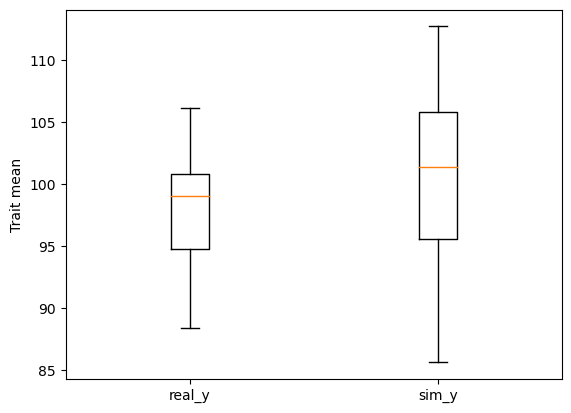

In [52]:
plt.boxplot([real_y, sim_y], labels=['real_y', 'sim_y'])

# Add labels and title
plt.xlabel('')
plt.ylabel('Trait mean')

# Show the plot
plt.show()

In [22]:
model.layers